References:
- scikit-learn toy dataset generation: https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py
- pytorch logistic regression tutorial: https://gist.github.com/loevlie/5044e62aea2ce625b70d6d6d75113d25
- Mozannar & Sontag repo: https://github.com/clinicalml/learn-to-defer/blob/master/synthetic/syntheticdata_reject.ipynb

In [2]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap

# Create environment

## Data generation

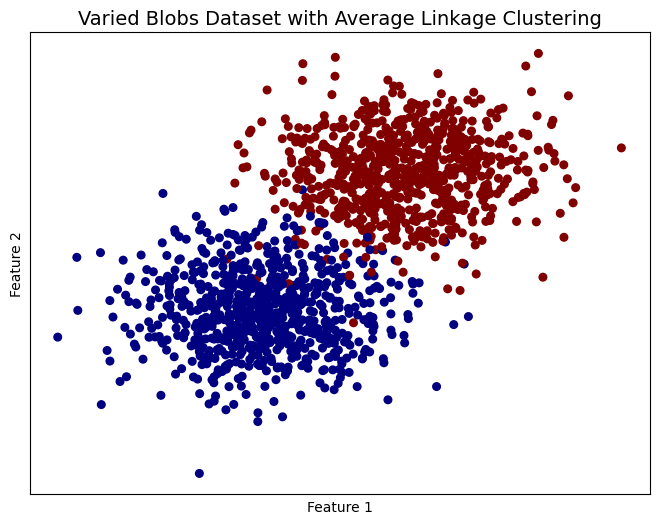

In [3]:
# Varied blobs dataset
n_samples = 1500
varied = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=2, cluster_std=[2.5, 2.5],random_state=1323)

X, y = varied # y binary 0,1

# Normalize the dataset (from scikit learn website)
X_normalized = StandardScaler().fit_transform(X)

# Agglomerative Clustering object with Average Linkage (from scikit learn website)
n_clusters = 2  # Number of clusters
average_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

# Fit data and cluster
cluster_labels = average_clustering.fit_predict(X_normalized)

# Visualize clusters
plt.figure(figsize=(8, 6))

plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap='jet')

plt.title('Varied Blobs Dataset with Average Linkage Clustering', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.show()

- Two clusters generated by two features (random arbitrary values) with binary responses (0,1)
- 0 and 1 evenly distributed (750 counts each)
- Not linearly separatable

## Methods

In [4]:
class LogisticRegression(torch.nn.Module):
    '''
    Logistic regression classifier from tutorial
    '''   
    def __init__(self, input_dim, output_dim=1):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        torch.nn.init.ones_(self.linear.weight)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [5]:
def expert_model(expert, data_x_train, data_y_train, data_x_test, data_y_test):
    '''
    Expert train and test classifier
    modified from tutorial
    '''
    epochs = 200_000
    learning_rate = 0.01
    losses = []
    losses_test = []
    Iterations = []
    iter = 0

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(expert.parameters(), lr=learning_rate)

    for epoch in tqdm(range(int(epochs))):
        input = data_x_train
        labels = data_y_train
        optimizer.zero_grad()  # Setting our stored gradients equal to zero
        outputs = expert(input)
        loss = criterion(torch.squeeze(outputs), labels)

        loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
        optimizer.step() # Updates weights and biases with the optimizer (SGD)

        iter += 1
        if iter%10000 == 0:
            # calculate Accuracy
            with torch.no_grad():
                # Calculating the loss and accuracy for the test dataset
                correct_test = 0
                total_test = 0
                outputs_test = torch.squeeze(expert(data_x_test))
                loss_test = criterion(outputs_test, data_y_test)
            
                predicted_test = outputs_test.round().detach().numpy()
                total_test += data_y_test.size(0)
                correct_test += np.sum(predicted_test == data_y_test.detach().numpy())
                accuracy_test = 100 * correct_test/total_test
                losses_test.append(loss_test.item())
            
                # Calculating the loss and accuracy for the train dataset
                total = 0
                correct = 0
                total += data_y_train.size(0)
                correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == data_y_train.detach().numpy())
                accuracy = 100 * correct/total
                losses.append(loss.item())
                Iterations.append(iter)

    print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
    print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")


In [6]:
def model_plot(model, X, y, title):
    '''
    Visualize classifier to build intuition
    modified from tutorial
    '''   
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()  
    
    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1])
    plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    plt.title(title)
    plt.show()

In [310]:
def classifier_plot(model, X, y):
    '''
    modified from tutorial to accomodate classifier and rejector model
    [0] = classifier and expert?
    [1] = expert?
    [2] = classifier?
    '''
    w_0 = model.fc.weight.detach().numpy()[0]
    b_0 = model.fc.bias.detach().numpy()[0]
    u_0 = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    #v_0 = (-w_0[0] * u_0 - b_0) / w_0[1]
    v_0 = (0.5-b_0-w_0[0]*u_0)/w_0[1]

    w_1 = model.fc.weight.detach().numpy()[1]
    b_1 = model.fc.bias.detach().numpy()[1]
    u_1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    #v_1 = (-w_1[0] * u_1 - b_1) / w_1[1]
    v_1 = (0.5-b_1-w_1[0]*u_1)/w_1[1]

    w_2 = model.fc.weight.detach().numpy()[2]
    b_2 = model.fc.bias.detach().numpy()[2]
    u_2 = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    #v_2 = (-w_2[0] * u_2 - b_2) / w_2[1]
    v_2 = (0.5-b_2-w_2[0]*u_2)/w_2[1]

    w_r = model.fc_rej.weight.detach().numpy()[0]
    b_r = model.fc_rej.bias.detach().numpy()[0]
    u_r = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    v_r = (0.5-b_r-w_r[0]*u_r)/w_r[1]
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
    plt.plot(u_0, v_0, color='red', label= '0')
    plt.plot(u_1, v_1, color='blue', label='1')
    plt.plot(u_2, v_2, color='green', label='2')
    plt.plot(u_r, v_r, color='black', label='r')
    plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    plt.legend()
    plt.show()

In [7]:
class Linear_net_rej(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim):
        super(Linear_net_rej, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+1) # out: 0,1,2
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax()

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

- "Querying the expert implies deferring the decision which incurs a cost l_exp(x, y, h)"
- "Without querying the expert implies that a classifier makes the final decision and incurs a cost l(x, y, y_hat)"
- "The classifier and expert costs are the logistic loss between the target and their predictions in the binary target setting"
- "Costs are the misclassifiction error with the target"


- "we can see that the loss on examples where the expert makes a mistake becomes the cross entropy loss with the target. On the other hand, when the expert agrees with the target, the learner faces two opposing decisions whether to defer or predict the target"

In [100]:
def reject_CrossEntropyLoss(outputs, h, labels, m, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert cost of classifier predicting (I_{m =y})
        labels: target
        m:  cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    #labels = torch.tensor(labels, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs =  -h*torch.log2( outputs[range(batch_size), rc]) - m*torch.log2(outputs[range(batch_size), labels])   # pick the values corresponding to the labels
    return torch.sum(outputs)/batch_size

- "The learned model should adapt to the underlying human expert in order to achieve better performance than deploying the model or expert individually"
- "We will only assume in this work that we are allowed access to samples of the experts decisions or to costs of deferring"

- Goal to learn two functions: 1) a classifier that can predict the target and 2) a rejector which decides whether the classifier or expert should predict
- The expert deferral pipeline, the rejector first r(x) decides who between the classifier m and expert h should predict and then whoever makes the final prediction incurs a specific cost
- "We only reject the classifier if it’s expected error is higher than the expected error of the expert"
- "We can encourage or hinder the action of deferral by modifying the loss with an additional parameter alpha"
- Purpose of alpha: "re-weight examples where the expert is correct to discourage the learner of fitting them and instead focus on examples where the expert makes a mistake"

In [324]:
def run_classifier_rej(model, expert, data_x, data_y, alpha):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        expert: expert model
        data_x: input
        data_y: label
        alpha: hyperparam alpha for loss L_CE^{\alpha}
    '''
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*50)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        inputs = data_x
        labels = data_y

        x_batches = torch.split(inputs,2)
        y_batches = torch.split(labels,2)  
        for inputs, labels in zip(x_batches, y_batches):
            # get the inputs; data is a list of [inputs, labels]

            optimizer.zero_grad()
            #inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to float32 if needed

            # forward + backward + optimize
            h = expert(inputs) # expert prediction
            _, predicted = torch.max(h.data, 1)
            h = (predicted==labels)*1
            m = [0] * len(inputs) # classifier
            for j in range (0,len(inputs)):
                if h[j]:
                    m[j] = alpha
                else:
                    m[j] = 1
            #h = torch.tensor(h)
            h = h.clone().detach()
            m = torch.tensor(m)
            outputs = model(inputs) # from classifier and rejector model
            loss = reject_CrossEntropyLoss(outputs, h, labels, m, 2)

            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

    #print('Finished Training')

In [341]:
def test_classifier_rej(model, expert, data_x, data_y):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0

    with torch.no_grad():
        inputs =  data_x
        labels = data_y
        h = expert(inputs)
        _, predicted_exp = torch.max(h.data, 1) # expert prediction
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #1 (ML), 2 (defer to expert)
        for i in range(len(inputs)):
            r = (predicted[i] == 2).item() # if 2, then defer to expert
            if r:
                exp += (predicted_exp[i] == labels[i]).item()
                correct_sys += (predicted_exp[i] == labels[i]).item()
                exp_total += 1
            else:
                correct += (predicted[i] == labels[i]).item() 
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
        real_total += labels.size(0)
    cov = str(total) + str(" out of") + str(real_total)

    #print("coverage", cov)
    print("system accuracy", 100 * correct_sys / real_total)
    print("expert accuracy",100* exp/(exp_total+0.0002))
    print("classifier accuracy", 100 * correct / (total + 0.0001))
    print()

    #return [100*total/real_total,  100*correct_sys/real_total, 100* exp/(exp_total+0.0002),100*correct/(total+0.0001) ]

In [78]:
# Split data into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, stratify=y, random_state=456)

# Create human experts

Baseline:
- Expert 1 (majority) is only good at classifying 1's
- Expert 2 (minority) is only good at classifying 0's
- To be modified to consider diverse experts

In [79]:
X_train_exp1 = torch.Tensor(X_train[y_train == 1])
y_train_exp1 = torch.Tensor(y_train[y_train == 1])

X_train_exp2 = torch.Tensor(X_train[y_train == 0])
y_train_exp2 = torch.Tensor(y_train[y_train == 0])

X_test_exp1 = torch.Tensor(X_test[y_test == 1])
y_test_exp1 = torch.Tensor(y_test[y_test == 1])

X_test_exp2 = torch.Tensor(X_test[y_test == 0])
y_test_exp2 = torch.Tensor(y_test[y_test == 0])

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

# Generate training dataset

## Both experts

100%|██████████| 200000/200000 [00:14<00:00, 14234.25it/s]


Iteration: 200000. 
Test - Loss: 0.05538797751069069. Accuracy: 98.66666666666667
Train -  Loss: 0.06537222862243652. Accuracy: 97.71428571428571



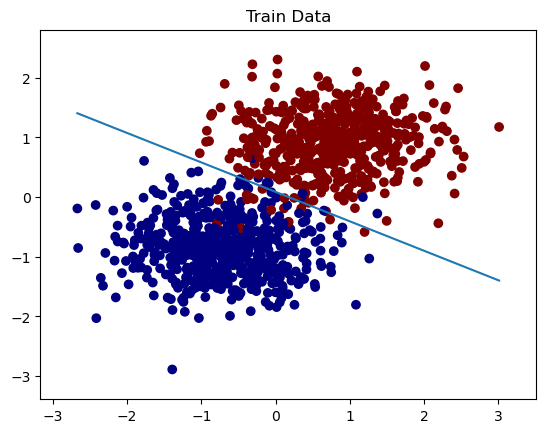

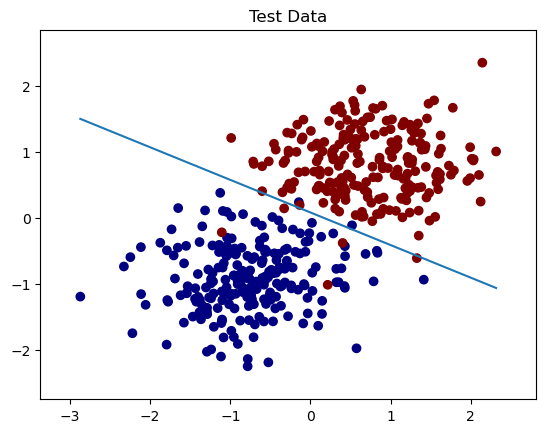

In [80]:
human_experts = LogisticRegression(2,1) # Two inputs x1 and x2, One possible output
expert_model(human_experts, X_train, y_train, X_test, y_test)
model_plot(human_experts, X_train, y_train, 'Train Data')
model_plot(human_experts, X_test, y_test, 'Test Data')

Both experts are able to leverage their knowledge and correctly classify 0s and 1s. The blue line divides 0s (blue) on the left and 1s (red) on the right. The accuracy is significantly high

## Only expert 1

100%|██████████| 200000/200000 [00:13<00:00, 15359.91it/s]


Iteration: 200000. 
Test - Loss: 0.0005958002875559032. Accuracy: 100.0
Train -  Loss: 0.0004947113338857889. Accuracy: 100.0



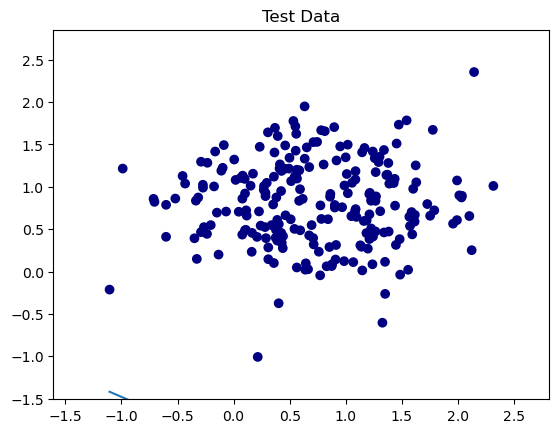

In [81]:
human_expert1 = LogisticRegression(2,1) # Two inputs x1 and x2, One possible output
expert_model(human_expert1, X_train_exp1, y_train_exp1, X_test_exp1, y_test_exp1)
model_plot(human_expert1, X_test_exp1, y_test_exp1, 'Test Data')

Expert 1 has a 100% accuracy on classifying only 1s

100%|██████████| 200000/200000 [00:13<00:00, 15233.92it/s]


Iteration: 200000. 
Test - Loss: 1.5408775806427002. Accuracy: 52.22222222222222
Train -  Loss: 0.0002486339071765542. Accuracy: 100.0



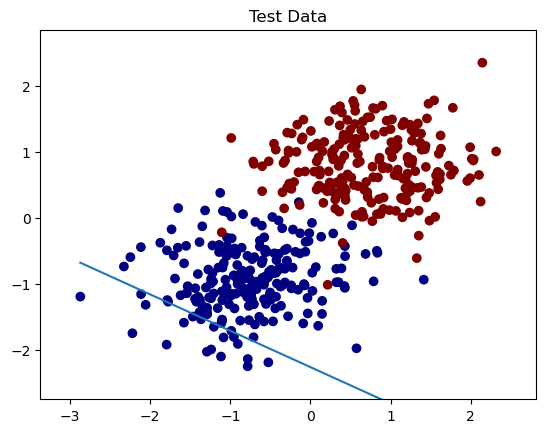

In [82]:
expert_model(human_expert1, X_train_exp1, y_train_exp1, X_test, y_test)
model_plot(human_expert1, X_test, y_test, 'Test Data')

Expert 1 is only good at classifying 1s and not 0s, therefore, 0s are mostly misclassified. The points on the right are classified as 1s and the left 0s. Expert 1 has an accuracy ~50%

## Only expert 2

100%|██████████| 200000/200000 [00:13<00:00, 15245.26it/s]

Iteration: 200000. 
Test - Loss: 0.00035186499007977545. Accuracy: 100.0
Train -  Loss: 0.0004838499007746577. Accuracy: 100.0



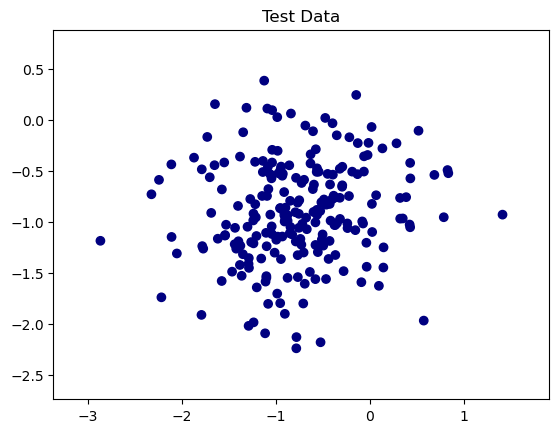

In [83]:
human_expert2 = LogisticRegression(2,1) # Two inputs x1 and x2, One possible output
expert_model(human_expert2, X_train_exp2, y_train_exp2, X_test_exp2, y_test_exp2)
model_plot(human_expert2, X_test_exp2, y_test_exp2, 'Test Data')

Expert 2 has a 100% accuracy on classifying only 0s

100%|██████████| 200000/200000 [00:13<00:00, 15169.93it/s]

Iteration: 200000. 
Test - Loss: 1.59214448928833. Accuracy: 51.77777777777778
Train -  Loss: 0.00016264904115814716. Accuracy: 100.0



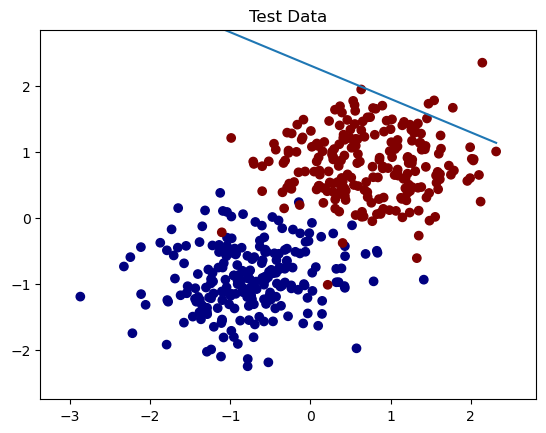

In [93]:
expert_model(human_expert2, X_train_exp2, y_train_exp2, X_test, y_test)
model_plot(human_expert2, X_test, y_test, 'Test Data')

Expert 2 is only good at classifying 0s and not 1s, therefore, 1s are mostly misclassified. The points on the right are classified as 1s and the left 0s. Expert 2 has an accuracy ~50%

# Train classifier and deferral

In [186]:
class_def_exp12 = Linear_net_rej(2,2)
alpha = 0
run_classifier_rej(class_def_exp12, human_experts, X_train, y_train, alpha)

# Test overall system

## Train with both experts and test with expert 1

In [298]:
test_classifier_rej(class_def_exp12, human_experts, X_test_exp1, y_test_exp1)

system accuracy 98.22222222222223
expert accuracy 0.0
classifier accuracy 99.99995475115169



/Users/michel.sh/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


- The classifer and expert model yields a 99.11% accuracy
- When deferred to the experts, the expert is unable to classify -> not deferred
- When not deferred to the experts, the classifier yields a 99.99% accuracy
- To be discussed why expert 1 who is able to classify 1s is part of the 0% accuracy

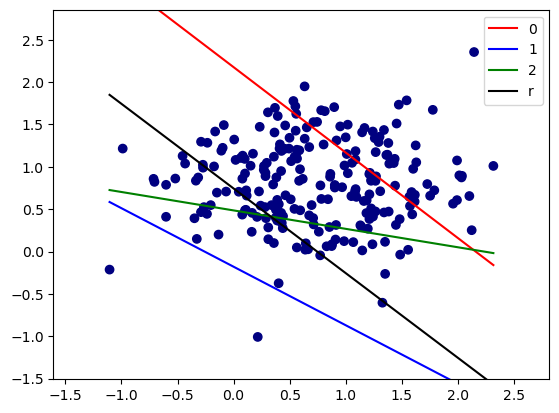

In [312]:
classifier_plot(class_def_exp12, X_test_exp1, y_test_exp1)

## Train with both experts and test with expert 2

In [277]:
test_classifier_rej(class_def_exp12, human_experts, X_test_exp2, y_test_exp2)

system accuracy 99.11111111111111
expert accuracy 99.99991031398177
classifier accuracy 0.0



- The classifier and expert model yields a 90.67% accuracy
- When deferred to the experts, the experts yields a 99.99% accuracy
- When not deferred to the experts, the classifier is unable to classify -> deferred
- To be discussed why expert 1 who is unable to classify 0s is part of the high expert accuracy
- To be discussed why classifier is unable to classify when trained with both experts

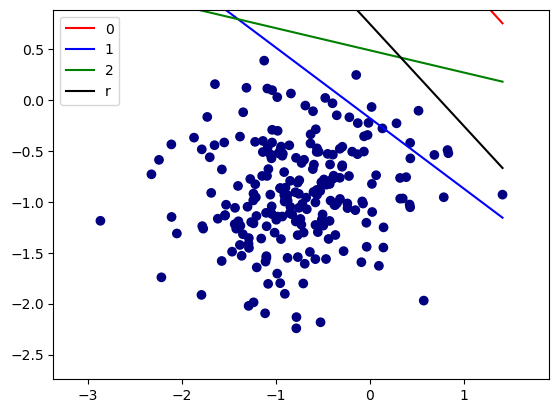

In [313]:
classifier_plot(class_def_exp12, X_test_exp2, y_test_exp2)

## Train with both experts and test with both experts

In [181]:
test_classifier_rej(class_def_exp12, human_experts, X_test, y_test)

system accuracy 98.66666666666667
expert accuracy 98.23779890942826
classifier accuracy 99.10309457260333



- The classifier and expert model yields a 98.67% accuracy
- When deferred to the experts, the expert yields a 98.24% accuracy
- When not deferred to the experts, the classifier yields a 99.10% accuracy
- This result could be due to both experts playing to their strengths which is expected, but the combined model does not outperform the model itself?

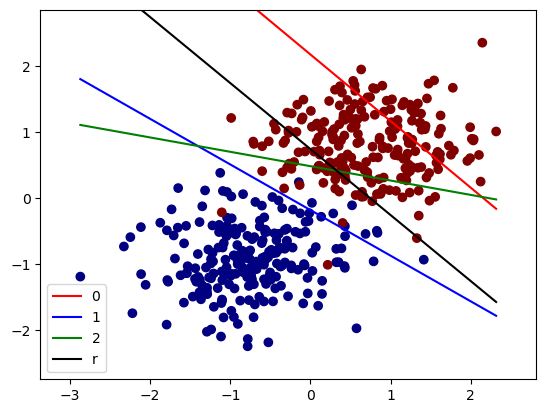

In [311]:
classifier_plot(class_def_exp12, X_test, y_test)